# Projet de cursus : Système Anti-Malware 
### Une approche utilisant la combinaisaon de modèles de deep learning et de machine learning pour la classification des malwares

**Auteurs :** M. Gosselin, Y. Emeriau, P. Ledermann, T. Boussin

**Classe :** 5CDI

**Année académique :** 2023-2024



Basé sur le papier de recherche : 

"Towards Building an Intelligent Anti-Malware System: A Deep Learning Approach using Support Vector Machine (SVM) for Malware Classification
Abien Fred M. Agarap"

## Partie 2 : Essai d'un modèle hybride : CNN-SVM

Pour cette partie, nous utilisons la librairie pytorch pour la définition des modèles

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

On charge les données : 

In [42]:
# Charger le fichier NPZ
data = np.load('images_malware.npz', allow_pickle=True)

# Afficher les clés disponibles dans le fichier NPZ
print("Clés disponibles dans le fichier NPZ :", list(data.keys()))

# Afficher les valeurs associées à chaque clé
for key in data.keys():
    print(f"Clé : {key}")
    print(f"Premier élément : \nMalware : \n{data[key][0][0]} \n\nType : \n  {data[key][0][1]} --> Adialer.C")  # Afficher la valeur associée à la clé

Clés disponibles dans le fichier NPZ : ['arr']
Clé : arr
Premier élément : 
Malware : 
[[  0   0   0 ...   0   0   0]
 [ 24   0  69 ...   0 144 255]
 [232 242 251 ... 235 139   0]
 ...
 [ 88 124 124 ...  95  92  56]
 [ 27 243 250 ... 250 243 243]
 [115  48 129 ... 199  23 252]] 

Type : 
  0 --> Adialer.C


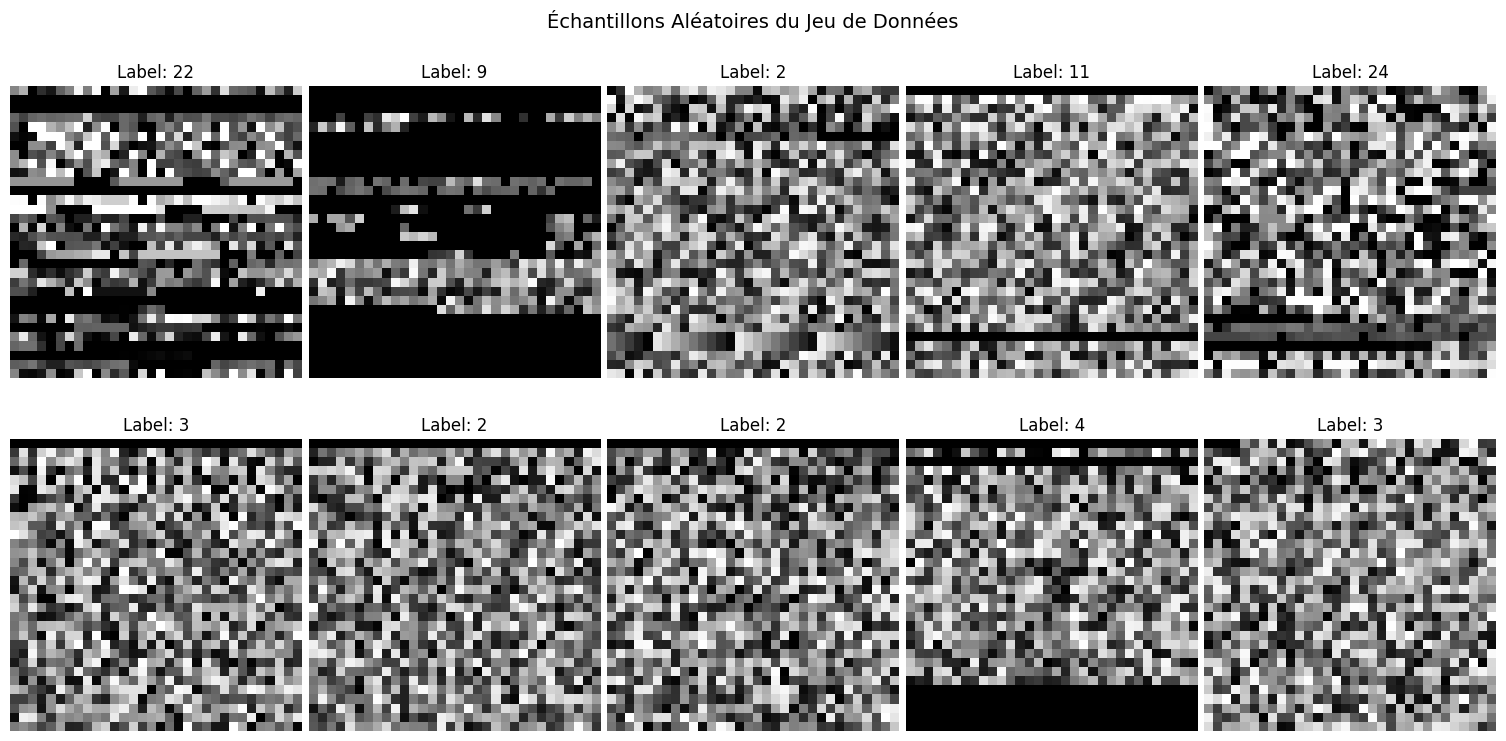

In [47]:
# Récupérer les données
images = data['arr'][:, 0]  # Supposons que les images sont dans la première colonne
labels = data['arr'][:, 1]  # Supposons que les étiquettes sont dans la deuxième colonne

# Nombre total d'images dans le dataset
total_images = len(images)

# Sélectionner 20 indices au hasard
random_indices = np.random.choice(total_images, size=10, replace=False)

# Afficher les images sélectionnées aléatoirement avec leurs étiquettes
num_images_per_row = 5
num_rows = (len(random_indices) - 1) // num_images_per_row + 1

plt.figure(figsize=(15, 8))  # Taille de la figure
plt.suptitle('Échantillons Aléatoires du Jeu de Données', fontsize=14)
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[idx], cmap='gray')  # Affichage en nuances de gris
    plt.title(f'Label: {labels[idx]}')
    plt.axis('off')  # Désactiver les axes

plt.tight_layout(pad=0.5)
plt.show()

Voilà à quoi ressemble les données contenues dans le dataset.

La prochaine étape consiste à effectuer la séparation du dataset en set pour le train et pour le test du model.

In [19]:
# Charger les données
data = np.load('images_malware.npz', allow_pickle=True)
images_labels = data['arr']

# Séparer les images et les étiquettes
images = []
labels = []
for img, label in images_labels:
    images.append(img)
    labels.append(label)

# Convertir en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
images, test_images, labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


# Conversion des images en tenseurs PyTorch
images_tensor = torch.from_numpy(images).float()
labels_tensor = torch.from_numpy(labels).long()
test_images_tensor = torch.from_numpy(images).float()
test_labels_tensor = torch.from_numpy(labels).long()

print("Data Type Image Tensor :", images_tensor.dtype)
print("Data Type Label Tensor :", labels_tensor.dtype)
print("Data Shape Image Tensor :", images_tensor.shape)
print("Data Shape Label Tensor :", labels_tensor.shape)


Data Type Image Tensor : torch.float32
Data Type Label Tensor : torch.int64
Data Shape Image Tensor : torch.Size([7471, 32, 32])
Data Shape Label Tensor : torch.Size([7471])


Le premier modèle que nous utilisons et un CNN-SVM. Il consiste à utilisons un modèle à couche convolutive pour traiter les images puis un modèle de SVM utilisant les données du CNN pour améliorer la classification. 

Voici le format du CNN : 

1. **INPUT:** 32 × 32 × 1
2. **CONV5:** 5 × 5 size, 36 filters, 1 stride
3. **LeakyReLU:** max(0.01hθ(x), hθ(x))
4. **POOL:** 2 × 2 size, 1 stride
5. **CONV5:** 5 × 5 size, 72 filters, 1 stride
6. **LeakyReLU:** max(0.01hθ(x), hθ(x))
7. **POOL:** 2 × 2 size, 1 stride
8. **FC:** 1024 Hidden Neurons
9. **LeakyReLU:** max(0.01hθ(x), hθ(x))
10. **DROPOUT:** p = 0.85
11. **FC:** 25 Output Classes


In [20]:
# Définir le modèle CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, kernel_size=5, stride=1, padding=2)
        self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(36, 72, kernel_size=5, stride=1, padding=2)
        self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(72 * 8 * 8, 1024)
        self.leaky_relu3 = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(p=0.85)
        self.fc2 = nn.Linear(1024, 25)

    def forward(self, x):
        x = self.pool1(self.leaky_relu1(self.conv1(x)))
        x = self.pool2(self.leaky_relu2(self.conv2(x)))
        x = x.view(-1, 72 * 8 * 8)  # Ajustement de la taille avant la couche FC
        x = self.dropout(self.leaky_relu3(self.fc1(x)))
        x = self.fc2(x)
        return x


# Créer un TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# DataLoader
batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = CNN()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)


In [21]:
"""# Entraîner le modèle
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Ajouter la dimension du canal
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')"""

"# Entraîner le modèle\nnum_epochs = 20\nfor epoch in range(num_epochs):\n    model.train()\n    running_loss = 0.0\n    for i, data in enumerate(data_loader, 0):\n        inputs, labels = data\n        optimizer.zero_grad()\n        outputs = model(inputs.unsqueeze(1))  # Ajouter la dimension du canal\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')"

On entraine la partie CNN et on affiche les résultats de l'entrainement

Epoch [1/200], Loss: 0.5028230398893356, Accuracy: 0.8124749029581046
Epoch [2/200], Loss: 0.4878274907668432, Accuracy: 0.8096640342658279
Epoch [3/200], Loss: 0.5026871641476949, Accuracy: 0.8107348413866953
Epoch [4/200], Loss: 0.4812641620635986, Accuracy: 0.8172935350020077
Epoch [5/200], Loss: 0.49023996690909066, Accuracy: 0.8134118591888636
Epoch [6/200], Loss: 0.48379960854848225, Accuracy: 0.8171596841118993
Epoch [7/200], Loss: 0.47992097834746045, Accuracy: 0.8142149645295141
Epoch [8/200], Loss: 0.47409655153751373, Accuracy: 0.8226475706063445
Epoch [9/200], Loss: 0.4679762214422226, Accuracy: 0.818632043903092
Epoch [10/200], Loss: 0.4594583163658778, Accuracy: 0.8194351492437425
Epoch [11/200], Loss: 0.4644124895334244, Accuracy: 0.8226475706063445
Epoch [12/200], Loss: 0.4564158707857132, Accuracy: 0.822781421496453
Epoch [13/200], Loss: 0.4514809022347132, Accuracy: 0.824387632177754
Epoch [14/200], Loss: 0.44658690293629966, Accuracy: 0.8251907375184045
Epoch [15/200

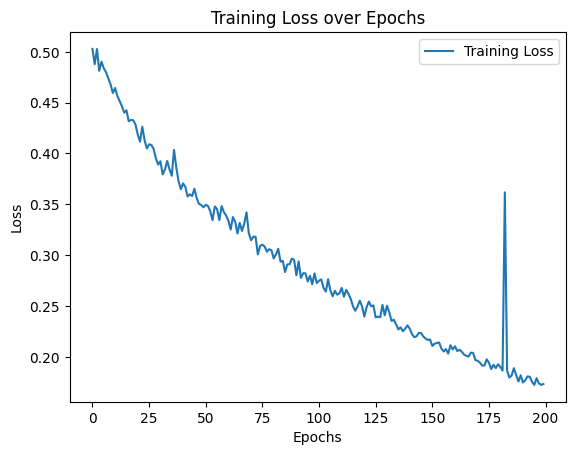

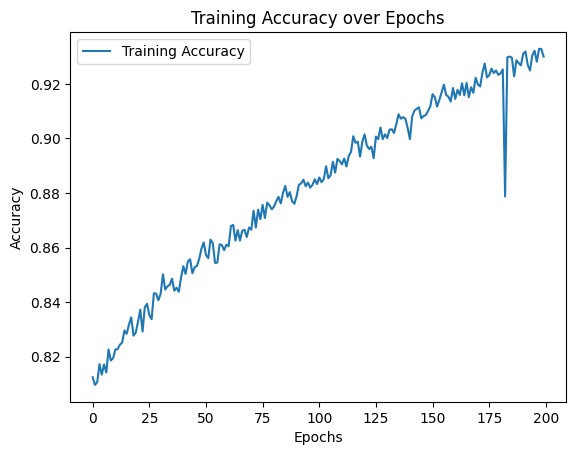

In [25]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Assuming inputs are grayscale images, adding channel dimension
        outputs = model(inputs.unsqueeze(1))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        running_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    average_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    # Store values for plotting
    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}, Accuracy: {accuracy}')

# Plot loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

# Plot accuracy
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy over Epochs')
plt.show()

Après avoir entrainé le modèle convolutif, on remarque une précision de plus de 90%. On pourrait passer plus de temps sur l'entrainement pour atteindre la convergence.

Ensuite l'objectif est de récupérer les embeddings du modèle convolutif (ce que le modèle à appris durant le training) et de s'en servir de base pour le modèle de machine learning : SVM.

In [26]:
from sklearn.svm import SVC

# Récupérer les embeddings des images après la première couche FC
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            outputs = model(inputs.unsqueeze(1))
            # Aplatir les embeddings pour les rendre compatibles avec le SVM
            embeddings.extend(outputs.view(outputs.size(0), -1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return embeddings, targets

# Obtenir les embeddings
embeddings, targets = get_embeddings(model, data_loader)

# Entraîner le SVM
svm = SVC(C=10, kernel='linear')
svm.fit(embeddings, targets)

SVC(C=10, kernel='linear')

Ci-dessous, l'entrainement du SVM à partir des données du CNN

In [27]:
# Créer un TensorDataset pour les données de test
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# DataLoader pour les données de test
test_batch_size = 256
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Obtenir les embeddings des données de test
test_embeddings, test_targets = get_embeddings(model, test_loader)

# Faire des prédictions sur les données de test avec le SVM
svm_predictions = svm.predict(test_embeddings)

# Calculer la précision
accuracy = accuracy_score(test_targets, svm_predictions)
print(f"Précision du SVM sur les données de test : {accuracy}")

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(test_targets, svm_predictions))

Précision du SVM sur les données de test : 0.9821978316155803
Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        97
           2       0.97      0.97      0.97      2357
           3       0.94      0.95      0.95      1281
           4       1.00      1.00      1.00       153
           5       1.00      1.00      1.00        88
           6       1.00      1.00      1.00       166
           7       1.00      1.00      1.00       119
           8       1.00      1.00      1.00       128
           9       1.00      1.00      1.00       128
          10       1.00      1.00      1.00       312
          11       1.00      1.00      1.00       342
          12       1.00      1.00      1.00       176
          13       1.00      1.00      1.00       143
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00  

Après avoir entrainé le modèle de SVM à partir des résultats du CNN, on obtient une précision pour la classification de 98%. Après avoir effectuer différents essais. La combinaison du SVM au CNN augmente la précision de la classification d'environ 6 % à 10 %. Ce qui est très significatif. 